In [1]:
import os
import tqdm
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.utils import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *

import librosa

In [2]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [3]:
### READ AND CONCAT DATA ###

label = pd.read_csv('profile.txt', sep='\t', header=None)
label.columns = ['Cooler','Valve','Pump','Accumulator','Flag']

df = pd.read_csv('EPS1.txt', sep='\t', header=None)

print(df.shape)
df.head()

(2205, 6000)


,0,1,2,3,4,5,6,7,8,9,...,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999
0,2411.6,2411.6,2411.6,2411.6,2411.6,2411.6,2411.6,2411.6,2411.6,2409.6,...,2409.6,2409.2,2409.6,2409.4,2409.6,2409.4,2409.6,2409.6,2409.6,2409.6
1,2409.6,2409.6,2409.6,2409.6,2409.6,2409.6,2409.6,2409.6,2409.6,2409.6,...,2398.8,2398.2,2398.2,2398.0,2398.0,2398.0,2398.0,2397.8,2397.8,2397.8
2,2397.8,2397.8,2397.8,2397.8,2397.8,2397.8,2397.8,2397.8,2397.8,2395.8,...,2383.8,2383.8,2383.8,2383.8,2383.8,2383.8,2383.8,2383.8,2383.8,2383.8
3,2383.8,2383.8,2383.8,2383.8,2383.8,2383.8,2383.8,2383.8,2382.8,2382.8,...,2373.2,2372.8,2372.6,2372.4,2372.2,2372.0,2372.0,2372.0,2372.0,2372.0
4,2372.0,2372.0,2372.0,2372.0,2372.0,2372.0,2372.0,2372.0,2372.0,2373.0,...,2370.0,2370.0,2369.8,2369.8,2369.8,2369.8,2369.6,2369.6,2369.6,2369.6


Text(0.5, 0, 'Time')

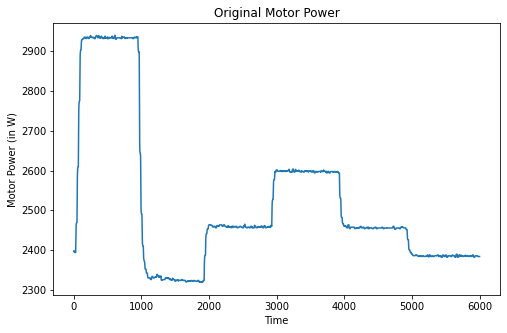

In [4]:
### PLOT ORIGINAL MOTOR POWER ###

df.iloc[2,:].plot(figsize=(8,5), title='Original Motor Power')
plt.ylabel('Motor Power (in W)'); plt.xlabel('Time')

In [5]:
### APPLY CLIPPING AND FIRST ORDER DIFFERECE ###

df = df.values
df = np.clip(np.diff(df, axis=1), -5,5)
df.shape

(2205, 5999)

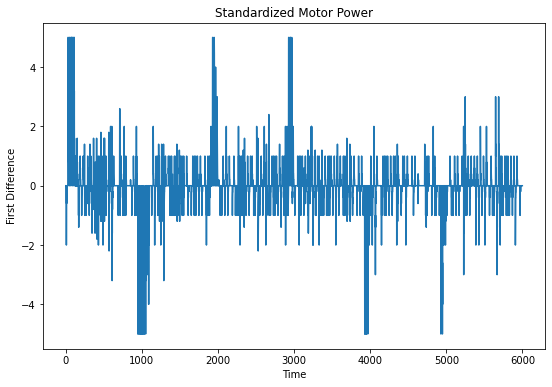

In [6]:
### PLOT STANDARDIZED DATA ###

plt.figure(figsize=(9,6))
plt.plot(df[2])
plt.title('Standardized Motor Power')
plt.ylabel('First Difference'); plt.xlabel('Time')
np.set_printoptions(False)

In [7]:
### LABEL DISTRIBUTION ###

label = label.Flag
label.value_counts()

0    1449
1     756
Name: Flag, dtype: int64

In [8]:
### LABEL ENCODING ###

diz_label = {0:'stable', 1:'not stable'}
y = to_categorical(label)

In [9]:
### APPLY MFCC TRANSFORMATION FOR EACH SIGNAL ###

df_mfcc = []

for i,sample in enumerate(tqdm.tqdm(df)):
    
    sample_mfcc = librosa.feature.mfcc(np.asfortranarray(sample),sr=40000)
    df_mfcc.append(sample_mfcc)
    
df_spectre = np.asarray(df_mfcc)
df_spectre = df_spectre.transpose(0,2,1)
df_spectre.shape

100%|█████████████████████████████████████████████████████████████████████████████| 2205/2205 [00:09<00:00, 222.94it/s]


(2205, 12, 20)

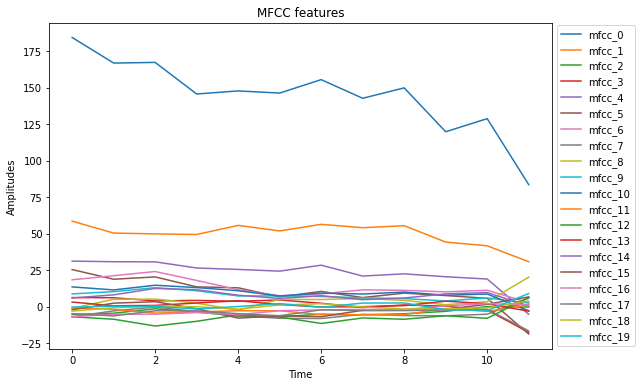

In [10]:
### PLOT MFCC FOR A SINGLE SIGNAL ###

plt.figure(figsize=(9,6))

plt.plot(df_spectre[2])
plt.legend(['mfcc_'+str(i) for i in range(df_spectre.shape[-1])], 
          loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('MFCC features')
plt.ylabel('Amplitudes'); plt.xlabel('Time')

np.set_printoptions(False)

In [11]:
### TRAIN TEST SPLIT ###

X_train, X_test, y_train, y_test = train_test_split(df_spectre, y, random_state = 42, test_size=0.2)

In [12]:
### DEFINE RESNET CNN ###

def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    

def get_model(data):
    
    set_seed(33)
        
    def residual_block(init, hidden_dim):
        
        init = Conv1D(hidden_dim, 3, activation='relu', padding="same")(init)
        
        x = Conv1D(hidden_dim, 3, activation='relu', padding="same")(init)
        x = Conv1D(hidden_dim, 3, activation='relu', padding="same")(x)
        x = Conv1D(hidden_dim, 3, activation='relu', padding="same")(x)
        skip = Add()([x, init])
        
        return skip
    
    inp = Input(shape=(data.shape[1], data.shape[2]))
    
    x = residual_block(inp, 256)
    x = residual_block(x, 128)
    x = residual_block(x, 32)
    x = GlobalMaxPool1D()(x)
    
    out = Dense(len(diz_label), activation='softmax')(x)
    
    model = Model(inputs=inp, outputs=out)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [13]:
es = EarlyStopping(monitor='val_accuracy', mode='auto', restore_best_weights=True, verbose=1, patience=15)

model = get_model(X_train)
model.fit(X_train, y_train, epochs=100, batch_size=256, verbose=2, validation_split=0.1, callbacks=[es])

Epoch 1/100
7/7 - 3s - loss: 6.6746 - accuracy: 0.5564 - val_loss: 1.6293 - val_accuracy: 0.4407
Epoch 2/100
7/7 - 3s - loss: 2.0541 - accuracy: 0.5532 - val_loss: 1.5703 - val_accuracy: 0.6215
Epoch 3/100
7/7 - 3s - loss: 0.8552 - accuracy: 0.6068 - val_loss: 0.5724 - val_accuracy: 0.7345
Epoch 4/100
7/7 - 3s - loss: 0.6669 - accuracy: 0.6194 - val_loss: 0.5776 - val_accuracy: 0.6497
Epoch 5/100
7/7 - 3s - loss: 0.5928 - accuracy: 0.6660 - val_loss: 0.6016 - val_accuracy: 0.6723
Epoch 6/100
7/7 - 3s - loss: 0.5572 - accuracy: 0.6862 - val_loss: 0.6777 - val_accuracy: 0.6384
Epoch 7/100
7/7 - 3s - loss: 0.5585 - accuracy: 0.6849 - val_loss: 0.5978 - val_accuracy: 0.6610
Epoch 8/100
7/7 - 3s - loss: 0.5307 - accuracy: 0.7095 - val_loss: 0.5675 - val_accuracy: 0.6836
Epoch 9/100
7/7 - 3s - loss: 0.5306 - accuracy: 0.7297 - val_loss: 0.5477 - val_accuracy: 0.7288
Epoch 10/100
7/7 - 3s - loss: 0.5422 - accuracy: 0.7196 - val_loss: 0.5575 - val_accuracy: 0.6780
Epoch 11/100
7/7 - 3s - loss:

In [14]:
### GET PREDICTED CLASS ON TEST ###

pred_test = np.argmax(model.predict(X_test), axis=1)

In [15]:
print(classification_report([diz_label[np.argmax(label)] for label in y_test], 
                            [diz_label[label] for label in pred_test]))

              precision    recall  f1-score   support

  not stable       0.72      0.72      0.72       147
      stable       0.86      0.86      0.86       294

    accuracy                           0.81       441
   macro avg       0.79      0.79      0.79       441
weighted avg       0.81      0.81      0.81       441



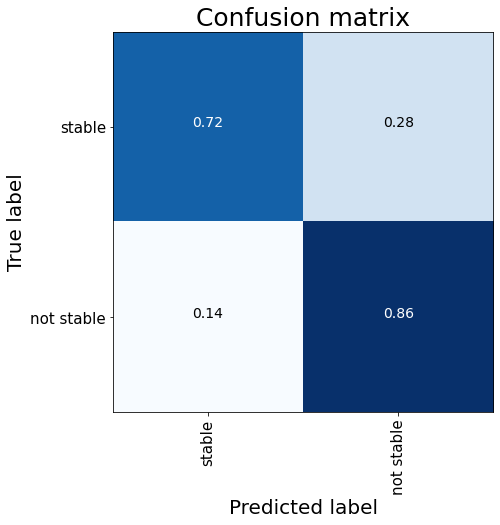

In [16]:
cnf_matrix = confusion_matrix([diz_label[np.argmax(label)] for label in y_test], 
                              [diz_label[label] for label in pred_test])

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=list(diz_label.values()))
plt.show()

In [17]:
### DUMMY CLASSIFIER ACCURACY (always stable) ###

sum([diz_label[np.argmax(label)] == 'stable' for label in y_test]) / len(pred_test)

0.6666666666666666